Creating feature matrix...
Analyzing feature correlations...


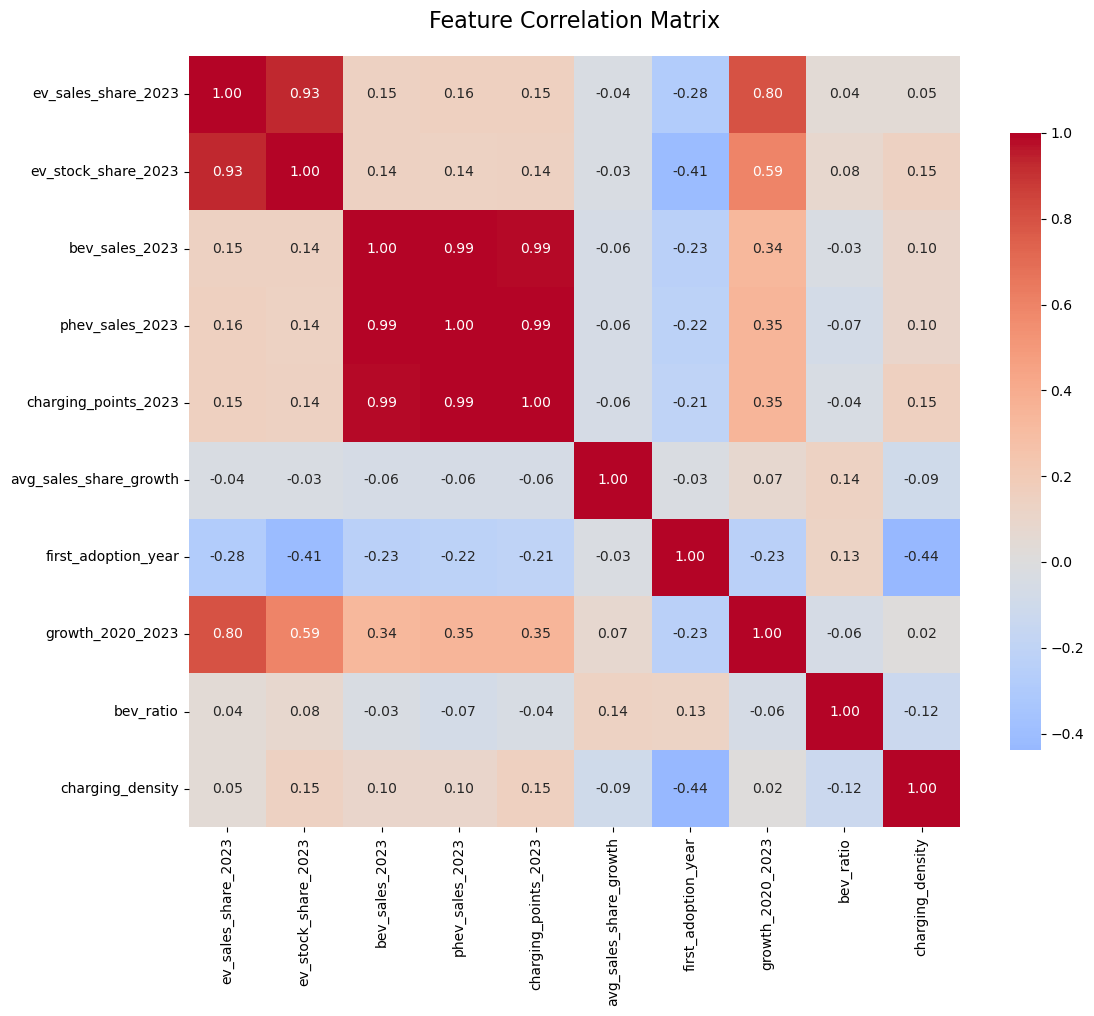

Highly correlated feature pairs: [('ev_sales_share_2023', 'ev_stock_share_2023'), ('bev_sales_2023', 'phev_sales_2023'), ('bev_sales_2023', 'charging_points_2023'), ('phev_sales_2023', 'charging_points_2023')]
Final features for clustering: ['ev_sales_share_2023', 'bev_sales_2023', 'charging_points_2023', 'avg_sales_share_growth', 'first_adoption_year', 'bev_ratio', 'charging_density']
Performing PCA dimensionality reduction
PCA dimensions after reduction: 6 (original: 7)
Performing K-Means clustering


  File "D:\workspace\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "D:\workspace\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\workspace\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "D:\workspace\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


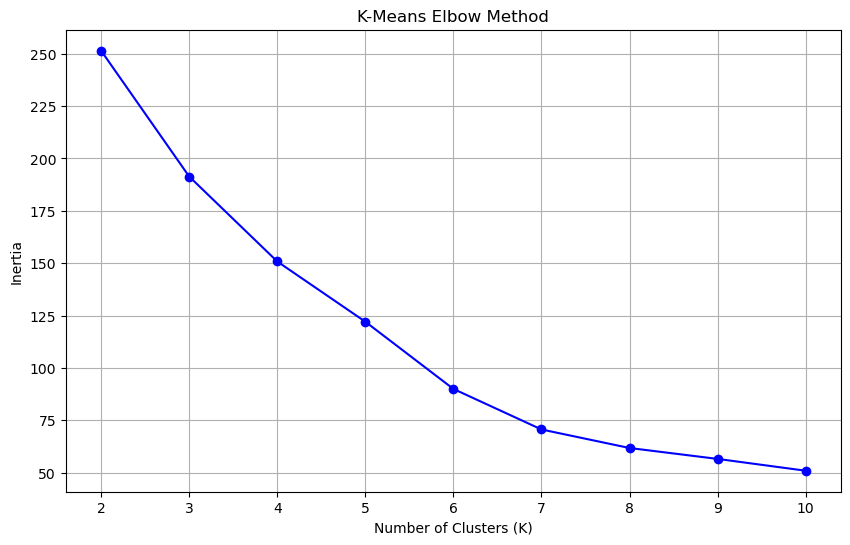

Clustering Results Analysis

Cluster 0 (contains 28 countries):
Countries: ['Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Chile', 'Denmark', 'EU27', 'Finland', 'France', 'Germany', 'Greece', 'Iceland', 'India', 'Italy', 'Japan', 'Korea', 'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'USA']

Cluster 1 (contains 18 countries):
Countries: ['Bulgaria', 'Colombia', 'Costa Rica', 'Croatia', 'Cyprus', 'Czech Republic', 'Estonia', 'Hungary', 'Ireland', 'Latvia', 'Lithuania', 'Luxembourg', 'Romania', 'Seychelles', 'Slovakia', 'Slovenia', 'South Africa', 'United Arab Emirates']

Cluster 2 (contains 2 countries):
Countries: ['Israel', 'Turkiye']

Cluster 3 (contains 1 countries):
Countries: ['China']


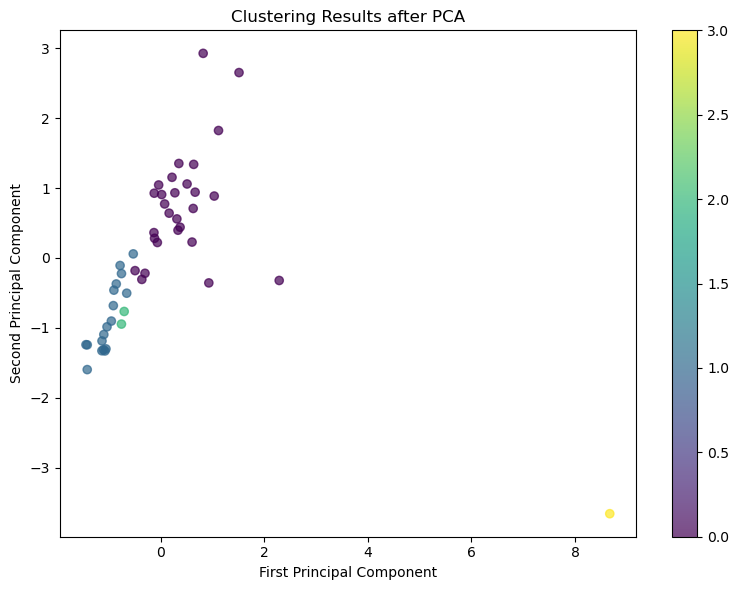

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('IEA Global EV Data 2024.csv')

#histery
df_historical = df[df['category'] == 'Historical'].copy()
exclude_regions = ['World', 'Europe', 'Rest of the world']
df_historical = df_historical[~df_historical['region'].isin(exclude_regions)]
df_cars = df_historical[df_historical['mode'] == 'Cars'].copy()
df_cars = df_cars[~df_cars['region'].isin(exclude_regions)]
#charging points
df_charging = df_historical[(df_historical['parameter'] == 'EV charging points') & (df_historical['mode'] == 'EV')].copy()
df_charging = df_charging[~df_charging['region'].isin(exclude_regions)]

def create_country_features(df_cars, df_charging):
    countries = df_cars['region'].unique()
    features = []
    for country in countries:
        country_data = df_cars[df_cars['region'] == country]
        feature_dict = {'region': country}
        data_2023 = country_data[country_data['year'] == 2023]
        ev_sales_share_2023 = data_2023[data_2023['parameter'] == 'EV sales share']['value'].iloc[0] if len(data_2023[data_2023['parameter'] == 'EV sales share']) > 0 else 0
        feature_dict['ev_sales_share_2023'] = ev_sales_share_2023
        ev_stock_share_2023 = data_2023[data_2023['parameter'] == 'EV stock share']['value'].iloc[0] if len(data_2023[data_2023['parameter'] == 'EV stock share']) > 0 else 0
        feature_dict['ev_stock_share_2023'] = ev_stock_share_2023
        bev_sales_2023 = data_2023[(data_2023['parameter'] == 'EV sales') & (data_2023['powertrain'] == 'BEV')]['value'].iloc[0] if len(data_2023[(data_2023['parameter'] == 'EV sales') & (data_2023['powertrain'] == 'BEV')]) > 0 else 0
        feature_dict['bev_sales_2023'] = bev_sales_2023
        phev_sales_2023 = data_2023[(data_2023['parameter'] == 'EV sales') & (data_2023['powertrain'] == 'PHEV')]['value'].iloc[0] if len(data_2023[(data_2023['parameter'] == 'EV sales') & (data_2023['powertrain'] == 'PHEV')]) > 0 else 0
        feature_dict['phev_sales_2023'] = phev_sales_2023
        charging_points_2023 = df_charging[(df_charging['region'] == country) & (df_charging['year'] == 2023)]['value'].sum()
        feature_dict['charging_points_2023'] = charging_points_2023
        sales_share_data = country_data[country_data['parameter'] == 'EV sales share'].sort_values('year')
        if len(sales_share_data) > 1:
            growth_rates = []
            for i in range(1, len(sales_share_data)):
                prev_value = sales_share_data.iloc[i-1]['value']
                curr_value = sales_share_data.iloc[i]['value']
                if prev_value > 0:
                    growth_rate = (curr_value - prev_value) / prev_value
                    growth_rates.append(growth_rate)
            avg_growth_rate = np.mean(growth_rates) if growth_rates else 0
        else:
            avg_growth_rate = 0
        feature_dict['avg_sales_share_growth'] = avg_growth_rate
        first_year = country_data[country_data['parameter'] == 'EV sales share']['year'].min()
        feature_dict['first_adoption_year'] = first_year if not pd.isna(first_year) else 2023
        data_2020 = country_data[(country_data['year'] == 2020) & (country_data['parameter'] == 'EV sales share')]
        sales_share_2020 = data_2020['value'].iloc[0] if len(data_2020) > 0 else 0
        growth_2020_2023 = ev_sales_share_2023 - sales_share_2020
        feature_dict['growth_2020_2023'] = growth_2020_2023
        total_ev_sales = bev_sales_2023 + phev_sales_2023
        bev_ratio = bev_sales_2023 / total_ev_sales if total_ev_sales > 0 else 0
        feature_dict['bev_ratio'] = bev_ratio
        charging_density = charging_points_2023 / (bev_sales_2023 + phev_sales_2023) if (bev_sales_2023 + phev_sales_2023) > 0 else 0
        feature_dict['charging_density'] = charging_density
        features.append(feature_dict)
    return pd.DataFrame(features)

print("Creating feature matrix...")
features_df = create_country_features(df_cars, df_charging)


clustering_features = [
    'ev_sales_share_2023',
    'ev_stock_share_2023', 
    'bev_sales_2023',
    'phev_sales_2023',
    'charging_points_2023',
    'avg_sales_share_growth',
    'first_adoption_year',
    'growth_2020_2023',
    'bev_ratio',
    'charging_density'
]

print("Analyzing feature correlations...")
correlation_matrix = features_df[clustering_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('feature_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

high_corr_features = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_features.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))
print(f"Highly correlated feature pairs: {high_corr_features}")

final_features = [
    'ev_sales_share_2023',
    'bev_sales_2023', 
    'charging_points_2023',
    'avg_sales_share_growth',
    'first_adoption_year',
    'bev_ratio',
    'charging_density'
]
print(f"Final features for clustering: {final_features}")

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df[final_features])

print("Performing PCA dimensionality reduction")
pca = PCA(n_components=0.95)
features_pca = pca.fit_transform(features_scaled)
print(f"PCA dimensions after reduction: {features_pca.shape[1]} (original: {features_scaled.shape[1]})")

print("Performing K-Means clustering")
inertias = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('K-Means Elbow Method')
plt.grid(True)
plt.savefig('kmeans_elbow_plot.png', dpi=300, bbox_inches='tight')
plt.show()

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features_pca)
features_df['cluster'] = cluster_labels

print("Clustering Results Analysis")
for cluster_id in range(4):
    cluster_data = features_df[features_df['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} (contains {len(cluster_data)} countries):")
    print(f"Countries: {list(cluster_data['region'])}")


fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(features_pca[:, 0], features_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_title('Clustering Results after PCA')
plt.colorbar(scatter, ax=ax)
plt.tight_layout()
plt.savefig('2010_2024_kmeans_clustering_results_pca.png', dpi=300, bbox_inches='tight')
plt.show()

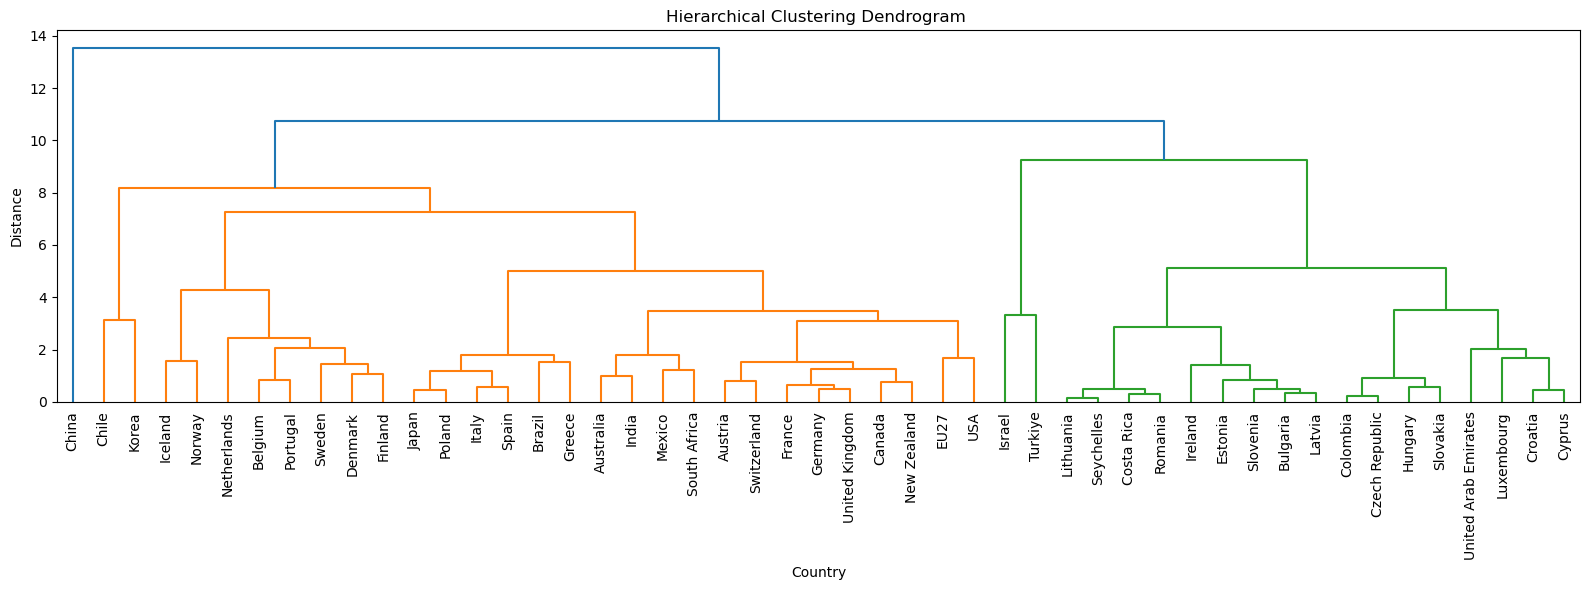

Hierarchical Clustering Results Analysis

Cluster 0 (contains 29 countries):
Countries: ['Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Chile', 'Denmark', 'EU27', 'Finland', 'France', 'Germany', 'Greece', 'Iceland', 'India', 'Italy', 'Japan', 'Korea', 'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'USA']

Cluster 1 (contains 2 countries):
Countries: ['Israel', 'Turkiye']

Cluster 2 (contains 17 countries):
Countries: ['Bulgaria', 'Colombia', 'Costa Rica', 'Croatia', 'Cyprus', 'Czech Republic', 'Estonia', 'Hungary', 'Ireland', 'Latvia', 'Lithuania', 'Luxembourg', 'Romania', 'Seychelles', 'Slovakia', 'Slovenia', 'United Arab Emirates']

Cluster 3 (contains 1 countries):
Countries: ['China']


In [9]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

Z = linkage(features_scaled, method='ward')
plt.figure(figsize=(16, 6))
dendrogram(
    Z,
    labels=features_df['region'].values,
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=None
)
plt.title('Hierarchical Clustering Dendrogram ')
plt.xlabel('Country')
plt.ylabel('Distance')
plt.tight_layout()
plt.savefig('2010_2024_Hierarchical_clustering_results.png', dpi=300, bbox_inches='tight')
plt.show()

n_clusters = 4
agg = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
hier_labels = agg.fit_predict(features_scaled)
features_df['hier_cluster'] = hier_labels

print("Hierarchical Clustering Results Analysis")
for cluster_id in range(n_clusters):
    cluster_data = features_df[features_df['hier_cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} (contains {len(cluster_data)} countries):")
    print(f"Countries: {list(cluster_data['region'])}")